## This module finds top 10 possible diseases based on each ML model for given symptoms

In [1]:
# Filter & ignore warnings for clear output visualization

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import all necessary packages

import os
import math
import random
import joblib
import pandas as pd
from statistics import mean
import matplotlib.pyplot as plt
from itertools import combinations

### Functions to find co-occuring symptoms with some threshold & process ML results to get list of diseases

In [3]:
# Function to generate top 10 diseases from the ML results
# Pass mean_score as another argument if you need probabilities too
def ProcessResultAndGenerateDiseases(top10_list, mean_score, cooccuring_symptoms, user_symptoms_len):
    
    global df_independent, all_symptoms, all_diseases
    top10_dict = {}

    # Checks for each disease, the matched symptoms & generates probability of having that disease
    for (idx, disease_id) in enumerate(top10_list):
        matched_symptoms = set()
        top10 = df_independent.loc[df_independent['Disease_Name'] == all_diseases[disease_id]].values.tolist()
        
        # Obtains the disease name which is at the top of the dataframe
        disease = top10[0].pop(0)

        # Each row contains 0s & 1s indicating whether a disease is associated with a particular symptom or not
        for (idx, value) in enumerate(top10[0]):
            if value != 0:
                matched_symptoms.add(all_symptoms[idx])
                
        #print("\n", matched_symptoms)
        probability = (len(matched_symptoms.intersection(set(cooccuring_symptoms))) + 1) / (user_symptoms_len + 1)
        top10_dict[disease] = round(probability * mean_score * 100, 2)
    
    top10_sorted_dict = dict(sorted(top10_dict.items(), key=lambda kv: kv[1], reverse=True))
    return top10_sorted_dict  
        

In [4]:
# Function to display the results from the dictionary
def PrintDictionary(top10_sorted_dict):
    for (key, value) in top10_sorted_dict.items():
        print(key, "\t", value, "%")


In [5]:
# Function to generate subsets
def GetPossibleSubsets(user_symptoms):
    
    global all_symptoms
    processed_symptoms = []
    user_symptoms_len = len(user_symptoms)
    minSubsetLength = math.floor(user_symptoms_len * 0.8)
    
    # Form possible subsets with minSubsetLength
    for combination in range(minSubsetLength, user_symptoms_len + 1):
        for subset in combinations(user_symptoms, combination):
            temp_processed_symptoms = [0 for x in range(0, len(all_symptoms))]
            for symptom in subset:
                temp_processed_symptoms[all_symptoms.index(symptom)] = 1
            processed_symptoms.append(temp_processed_symptoms)
    
    return processed_symptoms
    

In [6]:
# Function to get predictions for possible subsets from given symptoms
def GetTop10BySubsets(model, mean_score, user_symptoms, processed_symptoms):
    
    model_dict_res, res_dict = {}, {}
    user_symptoms_len = len(user_symptoms)
    subsets = 0
    
    for proc_sym in processed_symptoms:
        subsets += 1
        model_result = model.predict_proba([proc_sym])
        model_top10 = model_result[0].argsort()[-10:][::-1]
        model_dict = ProcessResultAndGenerateDiseases(model_top10, mean_score, user_symptoms, user_symptoms_len)

        for (key, value) in model_dict.items():
            if key not in model_dict_res.keys():
                model_dict_res[key] = [value, 1]
            else:
                model_dict_res[key] = [model_dict_res[key][0] + value, model_dict_res[key][1] + 1]
        #print(model_dict_res, "\n")
    
    #print("Total no. of subsets considered: ", subsets)
    for (key, value) in model_dict_res.items():
        res_dict[key] = round(value[0] / value[1], 2)
        
    res_dict = dict(sorted(res_dict.items(), key=lambda item: item[1], reverse=True)[:10])
    return res_dict


In [7]:
# Function to find co-occuring symptoms with all the symptoms user chosen
# We use a threshold to check for a 90% match with the given symptoms
def FindCooccuringSymptomsWithThreshold(user_symptoms):
    
    global df_independent, all_symptoms
    threshold = math.floor(len(user_symptoms) * 0.90)

    # Get all unique possible diseases with the given symptoms
    unique_diseases = set()
    for symptom in user_symptoms:
        possible_diseases_for_symptom = list(df_independent[df_independent[symptom] == 1]['Disease_Name'])
        for disease in possible_diseases_for_symptom:
            unique_diseases.add(disease)
        
    # Get all unique diseases & sort them
    unique_diseases = sorted(list(unique_diseases))
    
    #print(unique_diseases)

    # Obtain co-occuring symptoms with 90% threshold
    # cooccuring_symptoms must have all given symptoms by default
    cooccuring_symptoms = set(user_symptoms)   
    for disease in unique_diseases:
        
        # First, obtain all symptoms associated with each disease in unique diseases obtained
        symptoms_of_disease = df_independent.loc[df_independent['Disease_Name'] == disease].values.tolist().pop(0)

        # Maintain a temporary set of symptoms of the disease & add them only when they meet threshold requirements
        temp_symptoms = set()
        count, add_symptoms = 0, False
        for idx in range(len(symptoms_of_disease)):
            
            # Symptoms of a disease will have 1 in their respective symptom columns
            if symptoms_of_disease[idx] == 1:
                temp_symptoms.add(all_symptoms[idx-1])
                count = count + 1

                # Our threshold is set to 90% of original symptoms
                if count > threshold:
                    add_symptoms = True

        # Adds temporary symptoms to cooccuring symptoms only if they meet threshold requirements
        if add_symptoms == True:
            for symp in temp_symptoms:
                cooccuring_symptoms.add(symp)

    cooccuring_symptoms = sorted(list(cooccuring_symptoms))
    return cooccuring_symptoms
    

### Method to generate a random test set for evaluation

In [8]:
# Function to generate random test set

def GetRandomTestSet():
    
    # Required lists
    symptoms_count = []
    actual_diseases = []
    selected_list_of_symptoms = []

    # Testing with more than 10% of data from the dataset
    for i in range(0, 1501):

        # Increment counter
        i += 1

        # May have repetitions while picking disease
        random_disease = random.choice(all_diseases)
        actual_diseases.append(random_disease)
        
        # Get symptoms associated with the disease selected from the dataset
        # Dataframe will have the first element to be the column header. To avoid issues, we use +1 here
        disease_id = all_diseases.index(random_disease)
        disease_symptoms_list = df_independent.loc[df_independent['Disease_Name'] == all_diseases[disease_id]].values.tolist()
        disease_symptoms_list = disease_symptoms_list[0][1:]
        #print(disease_symptoms_list)
        
        # Each row contains 0s & 1s indicating whether a disease is associated with a particular symptom or not
        disease_symptoms = []
        index = 0
        for value in disease_symptoms_list:
            if value != 0:
                disease_symptoms.append(all_symptoms[index])
            index += 1
        #print(disease_symptoms)
        
        # Get random match threshold for symptoms
        threshold = random.choice(threshold_levels)
        
        # Get random symptoms from the associated symptoms with random threshold
        count_of_random_symptoms = math.floor(len(disease_symptoms) * threshold)
        symptoms_count.append(count_of_random_symptoms)
        
        random_symptoms = []
        for cnt in range(0, count_of_random_symptoms):
            random_symptoms.append(random.choice(disease_symptoms))
        selected_list_of_symptoms.append(random_symptoms)

    return actual_diseases, selected_list_of_symptoms, symptoms_count


### Prepares data to be compatible with the dataset to make predictions

In [9]:
# Load datasets for all possible combinations & for individual disease's respective symptoms

current_directory = os.getcwd()
current_directory = current_directory.replace("/Single-Use-Code", "")
data_path = current_directory + "/Datasets-CSV"
sav_path = current_directory + "/Model-Weights/"

df_combination = pd.read_csv(data_path + "/Disease_Symptom_Dataset_For_All_Symptom_Subsets.csv") 
df_independent = pd.read_csv(data_path + "/Disease_Symptom_Dataset_For_Respective_Symptoms.csv") 

X_combination = df_combination.iloc[:, 1:]
Y_combination = df_combination.iloc[:, 0:1]

X_independent = df_independent.iloc[:, 1:]
Y_independent = df_independent.iloc[:, 0:1]

# List of all possible symptoms
all_symptoms = list(X_independent.columns)
all_diseases = list(set(Y_independent['Disease_Name']))
all_diseases.sort()

# Set threshold levels
threshold_levels = [0.6, 0.7, 0.8, 0.9, 1.0]

# We obtain top 10 possible diseases
no_of_diseases = 10


### Evaluates the Project against the Test set

In [10]:
# This step takes around 5-8 mins
# Get the test set by randomization
actual_diseases, selected_list_of_symptoms, symptoms_count = GetRandomTestSet()
obtained_diseases = []
correct, wrong, isCorrect = 1, 1, False

# Dictionary of results for visualization
# key = count of symptoms considered
# value = [no. of such test items, no. of correct predictions for count "key"]
test_result_dict = {}

# For each list of symptoms, we run the test
for i in range(0, 1501):
    
    if i % 100 == 0:
        print("Processing test item ", i)
        
    user_symptoms = selected_list_of_symptoms[i]
    user_symptoms_len = len(set(user_symptoms))
    #print(user_symptoms)
    
    # Get possible subsets with minimum 90% count
    processed_symptoms = GetPossibleSubsets(user_symptoms)

    # Obtains all possible cooccuring symptoms including given symptoms
    cooccuring_symptoms = FindCooccuringSymptomsWithThreshold(user_symptoms)
    processed_symptoms2 = [0 for x in range(0, len(all_symptoms))]
    for symptom in cooccuring_symptoms:
        processed_symptoms2[all_symptoms.index(symptom)] = 1

    processed_symptoms.append(processed_symptoms2)
    #print(processed_symptoms)
    
    #print("Processing with Logistic Regression...")
    lr_cls = joblib.load(sav_path + "log_reg.sav")
    lr_mean_score = joblib.load(sav_path + "log_reg_cv.sav")
    lr_dict = GetTop10BySubsets(lr_cls, lr_mean_score, user_symptoms, processed_symptoms)
    #print("Done\n")
    #PrintDictionary(lr_dict)
    
    #print("Processing with Random Forest Classifier...")
    rf_cls = joblib.load(sav_path + "rand_forest.sav")
    rf_mean_score = joblib.load(sav_path + "rand_forest_cv.sav")
    rf_dict = GetTop10BySubsets(rf_cls, rf_mean_score, user_symptoms, processed_symptoms)
    #print("Done\n")
    #PrintDictionary(rf_dict)

    #print("Processing with KNN Classifier...")
    knn_cls = joblib.load(sav_path + "knn.sav")
    knn_mean_score = joblib.load(sav_path + "knn_cv.sav")
    knn_dict = GetTop10BySubsets(knn_cls, knn_mean_score, user_symptoms, processed_symptoms)
    #print("Done\n")
    #PrintDictionary(knn_dict)

    #print("Processing with Multinomial Naive Bayes...")
    mnb_cls = joblib.load(sav_path + "mnb.sav")
    mnb_mean_score = joblib.load(sav_path + "mnb_cv.sav")
    mnb_dict = GetTop10BySubsets(mnb_cls, mnb_mean_score, user_symptoms, processed_symptoms)
    #print("Done\n")
    #PrintDictionary(mnb_dict)
    
    # We use joint probabilities for the final dictionary & probabilities
    final_dict = {}

    # For Logistic Regression
    for (key, val) in lr_dict.items():
        if key not in final_dict:
            final_dict[key] = [lr_dict[key], 1]
        else:
            prob, count = final_dict[key]
            final_dict[key] = [lr_dict[key] + prob, 1 + count]

    # For Random Forest
    for (key, val) in rf_dict.items():
        if key not in final_dict:
            final_dict[key] = [rf_dict[key], 1]
        else:
            prob, count = final_dict[key]
            final_dict[key] = [rf_dict[key] + prob, 1 + count]

    # For KNN Classifier
    for (key, val) in knn_dict.items():
        if key not in final_dict:
            final_dict[key] = [knn_dict[key], 1]
        else:
            prob, count = final_dict[key]
            final_dict[key] = [knn_dict[key] + prob, 1 + count]

    # For Multinomial Naive Bayes
    for (key, val) in mnb_dict.items():
        if key not in final_dict:
            final_dict[key] = [mnb_dict[key], 1]
        else:
            prob, count = final_dict[key]
            final_dict[key] = [mnb_dict[key] + prob, 1 + count]

    # Sort dictionary by probabilities & leave off the less possible ones
    final_dict = dict(sorted(final_dict.items(), key=lambda item: item[1], reverse=True)[:10])
    
    # Update data for visualization by validating against actual data
    if actual_diseases[i] in final_dict.keys():
        obtained_diseases.append(actual_diseases[i])
        isCorrect = True
        correct += 1
    else:
        obtained_diseases.append("DISEASE_NOT_PREDICTED")
        isCorrect = False
        wrong += 1
        
    if symptoms_count[i] in test_result_dict.keys():
        values = test_result_dict[symptoms_count[i]]
        corrects = values[1]
        if isCorrect == True:
            corrects += 1
        test_result_dict[symptoms_count[i]] = [values[0] + 1, corrects]
        
    else:
        if isCorrect == True:
            test_result_dict[symptoms_count[i]] = [1, 1]
        else:
            test_result_dict[symptoms_count[i]] = [1, 0]
        
    if i == 1500:
        print("\nDone")
        

Processing test item  0
Processing test item  100
Processing test item  200
Processing test item  300
Processing test item  400
Processing test item  500
Processing test item  600
Processing test item  700
Processing test item  800
Processing test item  900
Processing test item  1000
Processing test item  1100
Processing test item  1200
Processing test item  1300
Processing test item  1400
Processing test item  1500

Done


### Evaluation Summary

In [11]:
# Max no. of symptoms for a disease considered in the project is 12
print("ANALYSIS ON RELATION BETWEEN NO. OF SYMPTOMS & SYSTEM ACCURACY\n")
for count in range(0, 13):
    if count in test_result_dict.keys():
        values = test_result_dict[count]
        accuracy_for_count = round(values[1] / values[0], 2) * 100
        print("Test accuracy on items with ", count, " symptoms is:\t", accuracy_for_count, "%")
        
    else:
        print("Test set do not contain items with ", count, " symptoms !!")
        
print("\n\nClearly, as the no. of input symptoms increases, the system performance increases !!")


ANALYSIS ON RELATION BETWEEN NO. OF SYMPTOMS & SYSTEM ACCURACY

Test accuracy on items with  0  symptoms is:	 0.0 %
Test accuracy on items with  1  symptoms is:	 88.0 %
Test accuracy on items with  2  symptoms is:	 92.0 %
Test accuracy on items with  3  symptoms is:	 97.0 %
Test accuracy on items with  4  symptoms is:	 100.0 %
Test accuracy on items with  5  symptoms is:	 100.0 %
Test accuracy on items with  6  symptoms is:	 100.0 %
Test accuracy on items with  7  symptoms is:	 100.0 %
Test accuracy on items with  8  symptoms is:	 100.0 %
Test accuracy on items with  9  symptoms is:	 100.0 %
Test accuracy on items with  10  symptoms is:	 100.0 %
Test accuracy on items with  11  symptoms is:	 100.0 %
Test accuracy on items with  12  symptoms is:	 100.0 %


Clearly, as the no. of input symptoms increases, the system performance increases !!


### Visualizes the Evaluation Results

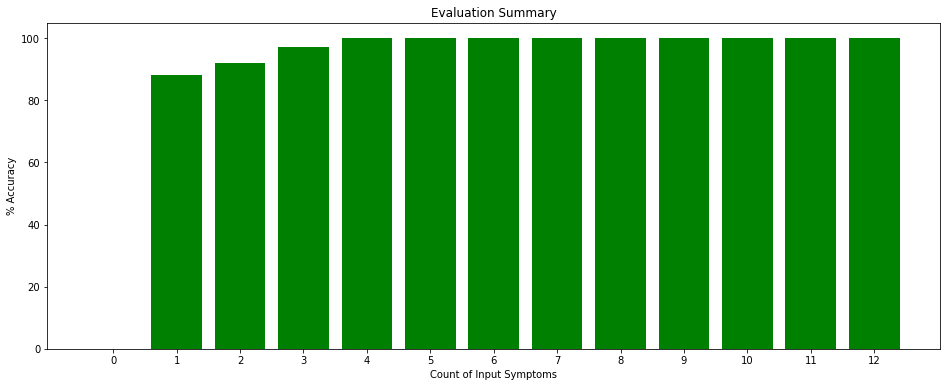

In [19]:
# Plots a bar chart
x_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
values = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for key in test_result_dict.keys():
    vals = test_result_dict[key]
    accuracy_val = round(vals[1] / vals[0], 2) * 100
    values[key] = accuracy_val
    
# Set title & labels
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot()

plt.title("Evaluation Summary")
plt.xlabel("Count of Input Symptoms")
plt.xticks(x_labels)
plt.ylabel("% Accuracy")

plt.bar(x_labels, values, color="green")
plt.show()
